In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error


In [2]:
##### I should do some filtering... Originally: 13960 cells 8009 genes

# Load dataset, with velocity values
    # these values are all normalized by scvelo
vdata = sc.read_h5ad("velocity_adata.h5ad")


In [3]:
# Scale Ms and velocity layer, with mean=0 and unit variance 
    # sc.pp.scale adds mean and std to var, although this relfects only last scaling
    # here we add the velocity scaling to the spliced counts scaling

sc.pp.scale(vdata, layer='Ms')
sc.pp.scale(vdata, layer='velocity')

In [4]:
##### Split data into train and test
    # watch out for time-ordering, randomly choose cells

test, train = train_test_split(vdata, test_size=0.5)

In [5]:
##### p-value for Klf2 Regression with 4000 genes at a time. 
# Run this a couple of times and keep the top 100 or so genes each time to compare. 

# data

# Update here.
genes_each_round = 4000

top = {}
num_added = []
r2_scores = []


for x in range(50):

    tf = 'Klf2'
    # starting at 7000, p-values are NaNs
    genes = random.sample(list(vdata.var_names), genes_each_round)

    X_train = train[:,genes].layers['velocity']
    y_train = train[:, tf].layers['Ms']

    X_test = test[:, genes].layers['velocity']
    y_test = test[:, tf].layers['Ms']

    #regression
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    params = np.append(lin.intercept_,lin.coef_)
    y_pred = lin.predict(X_test)


    # print R^2 value of current regression
    r2_scores += [r2_score(y_test, y_pred)]
    
    delta_y = y_test - y_pred


    # Here we append, why though? appending (6847, 1) and (6847, 6000) on axis= 1, then we get (6847, 6001). Is this necessary? 
    # We are adding one column of 1 infront of everything? Why?
    newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
    MSE = (sum((delta_y**2)))/(len(newX)-len(newX[0]))
    #print(MSE)

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,5)
    ts_b = np.round(ts_b,5)
    p_values = np.round(p_values,5)
    params = np.round(params,6)

    # I am not sure if this is right. Why do we need a column of 1s?
    names = ['1'] + genes

    myDF3 = pd.DataFrame()
    myDF3['Genes'],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [names, params,sd_b,ts_b,p_values]
    sortedDF = myDF3.sort_values(by=['Probabilities']).copy()
    
    #print(sortedDF)
    
    # so I want to keep a list of top 100 genes with p-value smaller than 0.05
    # I want to keep track of their coefficients -> should I save all of the coefficients? Or only focus on the coef. of genes always relevant? 
    # I want to plot the mean coef value of those genes. maybe along with how often it came up? color scale? 
    # i want to keep track of how often that gene has been under 0.05
    
    # and sortedDF['Genes'][:50] to limit to top 50... have to see how many there are like this. 
    
    num_added += [len(sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist())]
    
    for g in sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist():    
        if g in top:
            top[g] += [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
        else:
            top[g] = [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
        
            
print('Average R^2 Score: ', sum(r2_scores)/len(r2_scores), '\n')
names = np.array(list(top.items()))[:, 0]
count = np.array([len(top[g]) for g in top.keys()])
coef = np.array(list(top.values()))
coefmean = np.array([sum(top[g]) / len(top[g]) for g in top.keys()])




df = pd.DataFrame()
df['Genes'], df['Count'], df['Coef Mean'], df['Coefficients'] = [names, count, coefmean, coef]

# Update here.
sdf4 = df.reindex(df['Coef Mean'].abs().sort_values().index).copy()
num_added4 = num_added
print(sdf4)


Average R^2 Score:  0.9472485867104841 

            Genes  Count  Coef Mean  \
24          Cep44      1   0.021900   
11           Mul1      1   0.021959   
58         Acsbg1      1   0.022623   
51         Fip1l1      1  -0.022932   
37          Arl8a      1  -0.022953   
47          Srek1      1   0.023019   
15           Pigk      1   0.023045   
17          Smad2      1   0.023092   
38        Krtcap3      2   0.024064   
6             Nf1      1  -0.024178   
39          Klhl6      2   0.024407   
34         Klhdc1      1   0.024729   
1           Tceb3      1   0.024857   
35           Emp1      9   0.024858   
13         Sec61b      1  -0.024919   
53           Fli1      1  -0.024945   
19          Sike1      2  -0.025102   
43           Clpx      1   0.025145   
32          Tubb3      3   0.025183   
20           Lag3      2   0.025347   
16           Flna      3  -0.025426   
5          Prdm11      1  -0.025484   
29         Pik3r5      1   0.025946   
49       Trappc13      

In [6]:
##### p-value for Klf2 Regression with 1000 genes at a time. 
# Run this a couple of times and keep the top 100 or so genes each time to compare. 

# data

# Update here.
genes_each_round = 2500

top = {}
num_added = []
r2_scores = []

for x in range(50):
    
    tf = 'Klf2'
    # starting at 7000, p-values are NaNs
    genes = random.sample(list(vdata.var_names), genes_each_round)

    X_train = train[:,genes].layers['velocity']
    y_train = train[:, tf].layers['Ms']

    X_test = test[:, genes].layers['velocity']
    y_test = test[:, tf].layers['Ms']

    #regression
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    params = np.append(lin.intercept_,lin.coef_)
    y_pred = lin.predict(X_test)

    # print R^2 value of current regression
    r2_scores += [r2_score(y_test, y_pred)]
    
    

    delta_y = y_test - y_pred


    # Here we append, why though? appending (6847, 1) and (6847, 6000) on axis= 1, then we get (6847, 6001). Is this necessary? 
    # We are adding one column of 1 infront of everything? Why?
    newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
    MSE = (sum((delta_y**2)))/(len(newX)-len(newX[0]))
    #print(MSE)

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,5)
    ts_b = np.round(ts_b,5)
    p_values = np.round(p_values,5)
    params = np.round(params,6)

    # I am not sure if this is right. Why do we need a column of 1s?
    names = ['1'] + genes

    myDF3 = pd.DataFrame()
    myDF3['Genes'],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [names, params,sd_b,ts_b,p_values]
    sortedDF = myDF3.sort_values(by=['Probabilities']).copy()
    
    #print(sortedDF)
    
    # so I want to keep a list of top 100 genes with p-value smaller than 0.05
    # I want to keep track of their coefficients -> should I save all of the coefficients? Or only focus on the coef. of genes always relevant? 
    # I want to plot the mean coef value of those genes. maybe along with how often it came up? color scale? 
    # i want to keep track of how often that gene has been under 0.05
    
    # and sortedDF['Genes'][:50] to limit to top 50... have to see how many there are like this. 
    
    num_added += [len(sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist())]
    
    for g in sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist():    
        if g in top:
            top[g] += [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
        else:
            top[g] = [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
        
  
print('Average R^2 Score: ', sum(r2_scores)/len(r2_scores), '\n')   
names = np.array(list(top.items()))[:, 0]
count = np.array([len(top[g]) for g in top.keys()])
coef = np.array(list(top.values()))
coefmean = np.array([sum(top[g]) / len(top[g]) for g in top.keys()])


df = pd.DataFrame()
df['Genes'], df['Count'], df['Coef Mean'], df['Coefficients'] = [names, count, coefmean, coef]

# Update here.
# Sorted by absolute mean coefficeint values
sdf25 = df.reindex(df['Coef Mean'].abs().sort_values().index).copy()
num_added25 = num_added
print(sdf25)







Average R^2 Score:  0.941617158600596 

         Genes  Count  Coef Mean  \
1185     Tpgs1      2   0.000743   
2245     Atp5o      2   0.004627   
1341     Fcgrt      1   0.012196   
2051    Timm8b      1  -0.012291   
1239  AA467197      2  -0.012342   
...        ...    ...        ...   
286      Hsph1     13  -0.046866   
280     S100a6     15  -0.051965   
1         Ccl5     19   0.060993   
1269   Rasgrp2      9  -0.107280   
153   Hsp90aa1     18  -0.116568   

                                           Coefficients  
1185                              [-0.013502, 0.014987]  
2245                              [-0.016624, 0.025878]  
1341                                         [0.012196]  
2051                                        [-0.012291]  
1239                             [-0.012136, -0.012548]  
...                                                 ...  
286   [-0.04641, -0.037673, -0.054045, -0.045974, -0...  
280   [-0.064616, -0.043454, -0.061551, -0.054325, -...  
1    

In [7]:
##### p-value for Klf2 Regression with 1000 genes at a time. 
# Run this a couple of times and keep the top 100 or so genes each time to compare. 

# data

# Update here.
genes_each_round = 1000

top = {}
num_added = []
r2_scores = []

for x in range(50):
    
    tf = 'Klf2'
    # starting at 7000, p-values are NaNs
    genes = random.sample(list(vdata.var_names), genes_each_round)

    X_train = train[:,genes].layers['velocity']
    y_train = train[:, tf].layers['Ms']

    X_test = test[:, genes].layers['velocity']
    y_test = test[:, tf].layers['Ms']

    #regression
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    params = np.append(lin.intercept_,lin.coef_)
    y_pred = lin.predict(X_test)

    # print R^2 value of current regression
    r2_scores += [r2_score(y_test, y_pred)]
    
    

    delta_y = y_test - y_pred


    # Here we append, why though? appending (6847, 1) and (6847, 6000) on axis= 1, then we get (6847, 6001). Is this necessary? 
    # We are adding one column of 1 infront of everything? Why?
    newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
    MSE = (sum((delta_y**2)))/(len(newX)-len(newX[0]))
    #print(MSE)

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,5)
    ts_b = np.round(ts_b,5)
    p_values = np.round(p_values,5)
    params = np.round(params,6)

    # I am not sure if this is right. Why do we need a column of 1s?
    names = ['1'] + genes

    myDF3 = pd.DataFrame()
    myDF3['Genes'],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [names, params,sd_b,ts_b,p_values]
    sortedDF = myDF3.sort_values(by=['Probabilities']).copy()
    
    #print(sortedDF)
    
    # so I want to keep a list of top 100 genes with p-value smaller than 0.05
    # I want to keep track of their coefficients -> should I save all of the coefficients? Or only focus on the coef. of genes always relevant? 
    # I want to plot the mean coef value of those genes. maybe along with how often it came up? color scale? 
    # i want to keep track of how often that gene has been under 0.05
    
    # and sortedDF['Genes'][:50] to limit to top 50... have to see how many there are like this. 
    
    num_added += [len(sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist())]
    
    for g in sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist():    
        if g in top:
            top[g] += [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
        else:
            top[g] = [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
        
  
print('Average R^2 Score: ', sum(r2_scores)/len(r2_scores), '\n')   
names = np.array(list(top.items()))[:, 0]
count = np.array([len(top[g]) for g in top.keys()])
coef = np.array(list(top.values()))
coefmean = np.array([sum(top[g]) / len(top[g]) for g in top.keys()])


df = pd.DataFrame()
df['Genes'], df['Count'], df['Coef Mean'], df['Coefficients'] = [names, count, coefmean, coef]

# Update here.
sdf1 = df.reindex(df['Coef Mean'].abs().sort_values().index).copy()
num_added1 = num_added
print(sdf1)






Average R^2 Score:  0.8931002187428762 

         Genes  Count  Coef Mean  \
4995     Ppcdc      2   0.000003   
5176     Stx5a      2   0.000010   
3988      Ogfr      2   0.000011   
1605    Pde10a      2  -0.000012   
4440      Eaf1      2  -0.000024   
...        ...    ...        ...   
32        Rgcc      4   0.092029   
1200      Ccl5      7   0.094553   
3011    Slc9a7      9   0.110173   
2845   Rasgrp2      5  -0.213822   
17    Hsp90aa1      8  -0.222680   

                                           Coefficients  
4995                              [0.012426, -0.012419]  
5176                              [0.012726, -0.012706]  
3988                              [0.011524, -0.011501]  
1605                              [0.014898, -0.014923]  
4440                               [0.013123, -0.01317]  
...                                                 ...  
32               [0.085907, 0.103416, 0.090194, 0.0886]  
1200  [0.082462, 0.086432, 0.105193, 0.099683, 0.088...  
3011

In [8]:
print(sdf4[-10:])

            Genes  Count  Coef Mean  \
21           Atf3      1   0.033272   
8           Pde2a     10   0.034197   
10           Pvt1      1  -0.034446   
12         Slc9a7      3   0.034838   
36  2010111I01Rik      1  -0.037277   
9            Ccl5     23   0.047419   
50          Hsph1      1  -0.053182   
26        Tbc1d32      1  -0.056193   
7         Rasgrp2     22  -0.073133   
46       Hsp90aa1      2  -0.090443   

                                         Coefficients  
21                                         [0.033272]  
8   [0.027631, 0.032931, 0.039841, 0.034977, 0.029...  
10                                        [-0.034446]  
12                     [0.034906, 0.036993, 0.032615]  
36                                        [-0.037277]  
9   [0.047383, 0.048793, 0.047158, 0.05453, 0.0462...  
50                                        [-0.053182]  
26                                        [-0.056193]  
7   [-0.074789, -0.069872, -0.073429, -0.072098, -...  
46        

In [9]:
print(sdf25[-10:])

         Genes  Count  Coef Mean  \
317        Erg     11  -0.039939   
0        Pde2a     13   0.040404   
1395   Tbc1d32      8  -0.040596   
1817  Cacna2d2      1  -0.043823   
151     Slc9a7     18   0.044112   
286      Hsph1     13  -0.046866   
280     S100a6     15  -0.051965   
1         Ccl5     19   0.060993   
1269   Rasgrp2      9  -0.107280   
153   Hsp90aa1     18  -0.116568   

                                           Coefficients  
317   [-0.040576, -0.035056, -0.033373, -0.039798, -...  
0     [0.041805, 0.037979, 0.035205, 0.037543, 0.039...  
1395  [-0.051356, -0.030878, -0.04101, -0.038263, -0...  
1817                                        [-0.043823]  
151   [0.045476, 0.046562, 0.043041, 0.044832, 0.045...  
286   [-0.04641, -0.037673, -0.054045, -0.045974, -0...  
280   [-0.064616, -0.043454, -0.061551, -0.054325, -...  
1     [0.063855, 0.050617, 0.06434, 0.058505, 0.0895...  
1269  [-0.104608, -0.104546, -0.109973, -0.092367, -...  
153   [-0.143212, -0.11

In [10]:
print(sdf1[-10:])

              Genes  Count  Coef Mean  \
956   3110082I17Rik      4   0.080841   
1674         Pycard      3  -0.085224   
4642          Pde2a      5   0.086238   
3151           Vmp1      5   0.087625   
1920         S100a6      9  -0.092025   
32             Rgcc      4   0.092029   
1200           Ccl5      7   0.094553   
3011         Slc9a7      9   0.110173   
2845        Rasgrp2      5  -0.213822   
17         Hsp90aa1      8  -0.222680   

                                           Coefficients  
956            [0.063503, 0.086394, 0.088399, 0.085067]  
1674                  [-0.078621, -0.094521, -0.082531]  
4642  [0.092195, 0.078792, 0.099345, 0.076239, 0.08462]  
3151  [0.109231, 0.087278, 0.065102, 0.089481, 0.087...  
1920  [-0.066044, -0.070687, -0.098804, -0.12199, -0...  
32               [0.085907, 0.103416, 0.090194, 0.0886]  
1200  [0.082462, 0.086432, 0.105193, 0.099683, 0.088...  
3011  [0.102054, 0.111882, 0.132668, 0.106081, 0.119...  
2845  [-0.249042, -0.22799

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  1.,  2.,  5.,  8.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  6., 11., 10.,  5.,  2.,  0.,  0.,
         1.]),
 array([-0.0904435 , -0.08699695, -0.08355039, -0.08010384, -0.07665728,
        -0.07321073, -0.06976418, -0.06631762, -0.06287107, -0.05942452,
        -0.05597796, -0.05253141, -0.04908485, -0.0456383 , -0.04219175,
        -0.03874519, -0.03529864, -0.03185209, -0.02840553, -0.02495898,
        -0.02151242, -0.01806587, -0.01461932, -0.01117276, -0.00772621,
        -0.00427965, -0.0008331 ,  0.00261345,  0.00606001,  0.00950656,
         0.01295311,  0.01639967,  0.01984622,  0.02329278,  0.02673933,
         0.03018588,  0.03363244,  0.03707899,  0.04052554,  0.0439721 ,
         0.04741865]),
 <BarContainer object of 40 artists>)

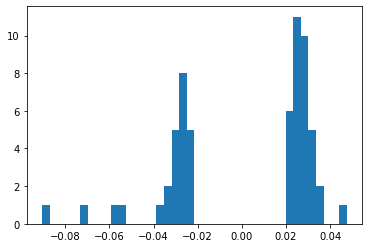

In [11]:
plt.hist(sdf4['Coef Mean'], bins=40)

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   3.,   6.,   8.,  33., 150.,
        876., 257.,   0.,   0.,   1.,   1.,   0., 817., 471.,  60.,  16.,
          8.,   3.,   1.,   1.,   0.,   0.,   1.]),
 array([-0.11656756, -0.11212855, -0.10768954, -0.10325053, -0.09881152,
        -0.09437251, -0.08993351, -0.0854945 , -0.08105549, -0.07661648,
        -0.07217747, -0.06773846, -0.06329945, -0.05886044, -0.05442144,
        -0.04998243, -0.04554342, -0.04110441, -0.0366654 , -0.03222639,
        -0.02778738, -0.02334838, -0.01890937, -0.01447036, -0.01003135,
        -0.00559234, -0.00115333,  0.00328568,  0.00772469,  0.01216369,
         0.0166027 ,  0.02104171,  0.02548072,  0.02991973,  0.03435874,
         0.03879775,  0.04323675,  0.04767576,  0.05211477,  0.05655378,
         0.06099279]),
 <BarContainer object of 40 artists>)

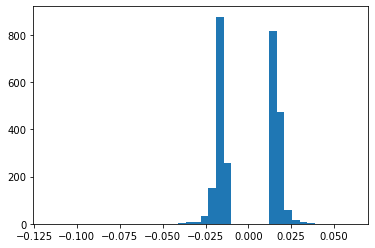

In [12]:
plt.hist(sdf25['Coef Mean'], bins=40)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 7.000e+00, 6.000e+00, 1.700e+01, 4.700e+01, 2.530e+02,
        1.646e+03, 8.320e+02, 1.270e+02, 5.000e+01, 1.959e+03, 7.740e+02,
        9.100e+01, 3.800e+01, 1.000e+01, 4.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([-0.22267962, -0.21435831, -0.206037  , -0.19771569, -0.18939438,
        -0.18107307, -0.17275176, -0.16443045, -0.15610914, -0.14778783,
        -0.13946652, -0.13114521, -0.1228239 , -0.11450259, -0.10618128,
        -0.09785997, -0.08953866, -0.08121735, -0.07289604, -0.06457473,
        -0.05625342, -0.04793211, -0.0396108 , -0.03128949, -0.02296818,
        -0.01464687, -0.00632556,  0.00199575,  0.01031706,  0.01863837,
         0.02695968,  0.03528099,  0.0436023 ,  0.05192361,  0.0

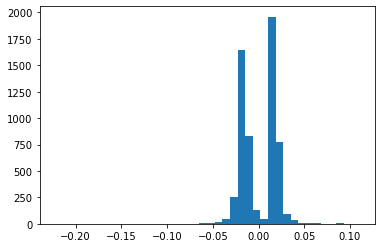

In [13]:
plt.hist(sdf1['Coef Mean'], bins=40)

(array([ 5., 15.,  0.,  9.,  0., 11.,  7.,  0.,  2.,  1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

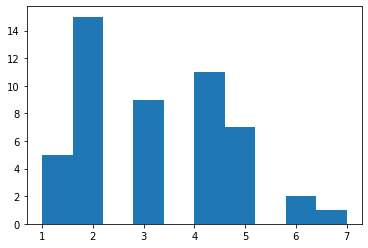

In [14]:
# verteilung wie viele gene pro lauf hinzugefügt wurden
plt.hist(num_added4)

(array([ 2.,  2.,  2.,  6.,  9., 11.,  8.,  6.,  2.,  2.]),
 array([113. , 118.6, 124.2, 129.8, 135.4, 141. , 146.6, 152.2, 157.8,
        163.4, 169. ]),
 <BarContainer object of 10 artists>)

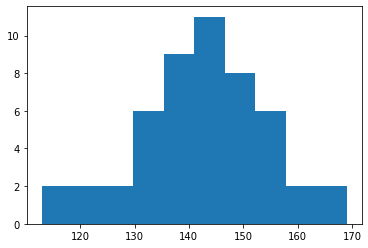

In [15]:
# how many genes were added in each run
plt.hist(num_added25)

(array([ 2.,  3.,  2.,  4.,  7., 14., 10.,  3.,  4.,  1.]),
 array([296. , 302.6, 309.2, 315.8, 322.4, 329. , 335.6, 342.2, 348.8,
        355.4, 362. ]),
 <BarContainer object of 10 artists>)

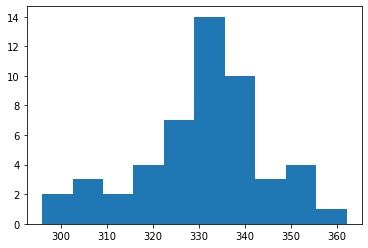

In [16]:
# how many genes were added in each run
plt.hist(num_added1)

These are the 10 genes with highest coefficients: 
            Genes  Count  Coef Mean
21           Atf3      1   0.033272
8           Pde2a     10   0.034197
10           Pvt1      1  -0.034446
12         Slc9a7      3   0.034838
36  2010111I01Rik      1  -0.037277
9            Ccl5     23   0.047419
50          Hsph1      1  -0.053182
26        Tbc1d32      1  -0.056193
7         Rasgrp2     22  -0.073133
46       Hsp90aa1      2  -0.090443

These are the 10 most frequent genes: 
      Genes  Count  Coef Mean
32    Tubb3      3   0.025183
14  Izumo1r      3  -0.029692
31     Gas7      3   0.028336
30     Rgcc      4   0.032554
23      Fry      5   0.031328
35     Emp1      9   0.024858
8     Pde2a     10   0.034197
3      Klf2     14  -0.030905
7   Rasgrp2     22  -0.073133
9      Ccl5     23   0.047419


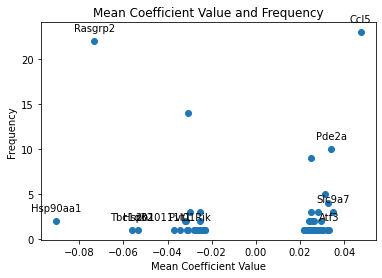

In [17]:
##### scatter of mean coeficient against how often gene was counted

df = sdf4

# plot points
plt.scatter(df['Coef Mean'], df['Count'])

# plot labels
plt.title('Mean Coefficient Value and Frequency')
plt.xlabel('Mean Coefficient Value')
plt.ylabel('Frequency')

# zip joins x and y coordinates in pairs
for x,y,g in zip(df['Coef Mean'][-10:], df['Count'][-10:], df['Genes'][-10:]):

    label = g

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

print('These are the 10 genes with highest coefficients: ')
print(df[['Genes', 'Count', 'Coef Mean']][-10:])
print()
print('These are the 10 most frequent genes: ')
print(df.sort_values(by=['Count'])[['Genes', 'Count', 'Coef Mean']][-10:])


# ein anderer lauf.. schon etwas variation, vorallem bei Klf2

#10    Slc9a7      6   0.032609   
#2       Rgcc      7   0.033383   
#9       Ccl5     11   0.046270   
#19      Klf2     15  -0.027694   
#0    Rasgrp2     27  -0.073179   

These are the 10 genes with highest coefficients: 
         Genes  Count  Coef Mean
317        Erg     11  -0.039939
0        Pde2a     13   0.040404
1395   Tbc1d32      8  -0.040596
1817  Cacna2d2      1  -0.043823
151     Slc9a7     18   0.044112
286      Hsph1     13  -0.046866
280     S100a6     15  -0.051965
1         Ccl5     19   0.060993
1269   Rasgrp2      9  -0.107280
153   Hsp90aa1     18  -0.116568

These are the 10 most frequent genes: 
              Genes  Count  Coef Mean
1164           Arf4     17   0.029752
829          Nfkbia     17   0.032344
298          S100a4     17  -0.024847
16            Tubb3     18   0.027526
151          Slc9a7     18   0.044112
153        Hsp90aa1     18  -0.116568
1              Ccl5     19   0.060993
759          Slc7a5     19   0.029633
432           Raph1     20   0.026981
281   3110082I17Rik     22   0.034242


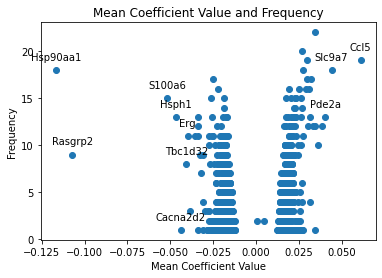

In [18]:
##### scatter of mean coeficient against how often gene was counted

df = sdf25

# plot points
plt.scatter(df['Coef Mean'], df['Count'])

# plot labels
plt.title('Mean Coefficient Value and Frequency')
plt.xlabel('Mean Coefficient Value')
plt.ylabel('Frequency')

# zip joins x and y coordinates in pairs
for x,y,g in zip(df['Coef Mean'][-10:], df['Count'][-10:], df['Genes'][-10:]):

    label = g

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

print('These are the 10 genes with highest coefficients: ')
print(df[['Genes', 'Count', 'Coef Mean']][-10:])
print()
print('These are the 10 most frequent genes: ')
print(df.sort_values(by=['Count'])[['Genes', 'Count', 'Coef Mean']][-10:])

These are the 10 genes with highest coefficients: 
              Genes  Count  Coef Mean
956   3110082I17Rik      4   0.080841
1674         Pycard      3  -0.085224
4642          Pde2a      5   0.086238
3151           Vmp1      5   0.087625
1920         S100a6      9  -0.092025
32             Rgcc      4   0.092029
1200           Ccl5      7   0.094553
3011         Slc9a7      9   0.110173
2845        Rasgrp2      5  -0.213822
17         Hsp90aa1      8  -0.222680

These are the 10 most frequent genes: 
        Genes  Count  Coef Mean
1233   Setbp1     11  -0.027507
745   Ppp2r2d     12   0.025707
405     Arl8a     12  -0.026443
2147    Zmat2     12   0.019192
694    Zbtb37     12  -0.022271
451   Cables1     12  -0.022912
971     Zmiz1     12   0.023259
1088     Atg7     12   0.025228
2117     Cd83     13   0.037371
1456     Nptn     16   0.055279


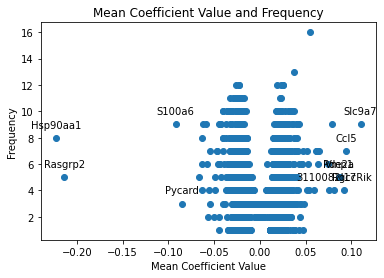

In [19]:
##### scatter of mean coeficient against how often gene was counted

df = sdf1

# plot points
plt.scatter(df['Coef Mean'], df['Count'])

# plot labels
plt.title('Mean Coefficient Value and Frequency')
plt.xlabel('Mean Coefficient Value')
plt.ylabel('Frequency')

# zip joins x and y coordinates in pairs
for x,y,g in zip(df['Coef Mean'][-10:], df['Count'][-10:], df['Genes'][-10:]):

    label = g

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

print('These are the 10 genes with highest coefficients: ')
print(df[['Genes', 'Count', 'Coef Mean']][-10:])
print()
print('These are the 10 most frequent genes: ')
print(df.sort_values(by=['Count'])[['Genes', 'Count', 'Coef Mean']][-10:])

In [20]:
df = pd.DataFrame()
df['Names'], df['Numbers'] = [['a', 'b', 'c', 'd'], [1, 2, 3, 4]]
[x for x in df['Names'][:1]]



['a']